# *Tutorial: Understanding 4F Optical Systems with Pado 🌊*
This jupyter notebook demonstrates how to implement and simulate a 4F optical system using `Pado`. Through this notebook, you will learn how to apply frequency domain filtering in batch mode using the fundamental components of `Pado`.


---

## 🌊 **Step 1: Setup Environment**
First, let's set up our working environment by navigating to the correct directory.


In [1]:
cd ../..

c:\Users\PC\Desktop\pado


## 🔧 **Step 2: Import Required Libraries**
Let's import the necessary libraries and modules from Pado.

In [2]:
import torch
import numpy as np
from pado.light import Light
from pado.propagator import Propagator
from pado.optical_element import RefractiveLens


## 📊 **Step 3: Define System Parameters**
We need to set up our optical system parameters including dimensions, pixel pitch, wavelength, and focal length.


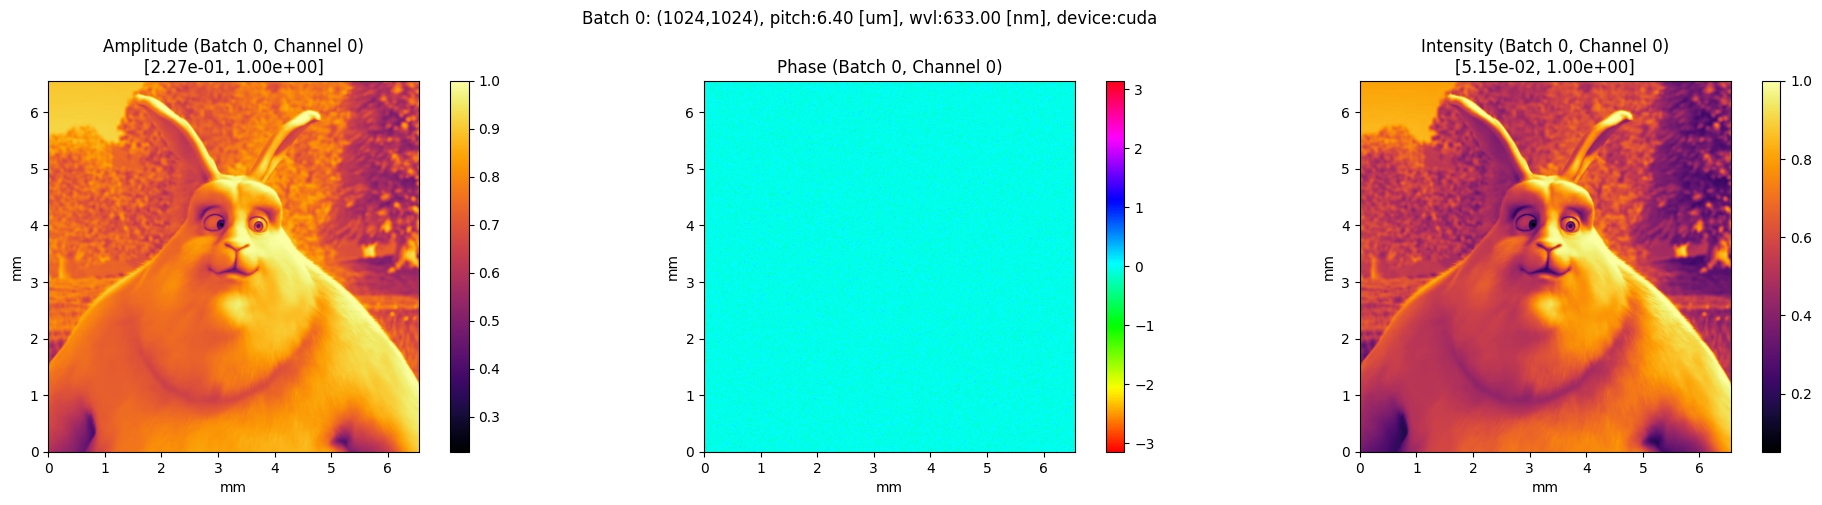

In [3]:
# System parameter settings
dim = (4, 1, 1024, 1024)  # (batch, channel, height, width)
pitch = 6.4e-6  # pixel size (m)
wvl = 633e-9    # wavelength (m)
f = 0.1         # focal length (m)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load image and create initial wavefront with 4 batches
input_light = Light(dim, pitch, wvl, device=device)

input_light.load_image(r'example\asset\bunny_1_1.PNG', random_phase=True, std=0.1, distribution='von_mises')
input_light.visualize()

# Create propagator and lenses
prop = Propagator('ASM')
lens1 = RefractiveLens(dim, pitch, focal_length=f, wvl=wvl, device=device)
lens2 = RefractiveLens(dim, pitch, focal_length=f, wvl=wvl, device=device)


## 🔍 **Step 4: Define Helper Functions**
Here we define two important functions:
1. `create_batch_filters`: Creates different frequency filters for batch processing
2. `apply_4F_system`: Implements the 4F optical system with frequency filtering


In [4]:
def create_batch_filters(dim, pitch, radius_ratios=[0.10, 0.05, 0.06, 0.03], 
                         filter_types=['low', 'low', 'high', 'high']):
    """Create frequency filters for each batch
    
    Args:
        dim: Dimensions of the filter
        pitch: Pixel pitch 
        radius_ratios: List of radius ratios for each batch
        filter_types: List of filter types for each batch ('low' or 'high')
    """
    center_y, center_x = dim[2]//2, dim[3]//2
    y, x = np.ogrid[-center_y:dim[2]-center_y, -center_x:dim[3]-center_x]
    r = np.sqrt(x*x + y*y)
    
    # Create filter_light with batch dimension of 4
    filter_light = Light(dim, pitch, wvl, device=device)
    
    # Create masks for each batch
    masks = []
    for i in range(dim[0]):
        inner_radius = min(center_y, center_x) * radius_ratios[i]
        mask = r < inner_radius if filter_types[i] == 'low' else r > inner_radius
        masks.append(mask)
    
    # Stack masks along batch dimension
    mask_tensor = torch.stack([torch.tensor(mask, device=device).float() for mask in masks])
    mask_tensor = mask_tensor.unsqueeze(1)  # Add channel dimension
    
    # Set amplitude to the combined mask tensor
    filter_light.set_amplitude(mask_tensor)
    
    return filter_light

# Implementation of 4F system for batched processing
def apply_4F_system(input_light, lens1, lens2, filter_light):
    """Apply 4F system with filters in batch mode.
    
    Args:
        input_light: Input light field with multiple batches
        lens1, lens2: Two lenses
        filter_light: Filter light field with multiple batches
    """
    # Propagate first F distance
    light = prop.forward(input_light, f)
    
    # Pass through first lens
    light = lens1.forward(light)
    
    # Propagate second F distance (Fourier plane)
    light = prop.forward(light, f)
    
    light.visualize(b=0)  # Visualize first batch at Fourier plane
    
    # Apply frequency filter - each batch gets its respective filter
    light.set_field(light.get_field() * filter_light.get_field())
    
    # Visualize all filters using a loop
    for b in range(filter_light.dim[0]):
        filter_light.visualize(b=b)  # Visualize filter for each batch
    
    light.visualize(b=0)  # Visualize first batch after filtering
    
    # Propagate third F distance
    light = prop.forward(light, f)
    
    # Pass through second lens
    light = lens2.forward(light)
    
    # Propagate fourth F distance (image plane)
    light = prop.forward(light, f)
    
    return light

## 🧪 **Step 5: Run the 4F System Simulation**
Now we'll create different filters for each batch and apply the 4F system to see how different frequency filters affect the image.


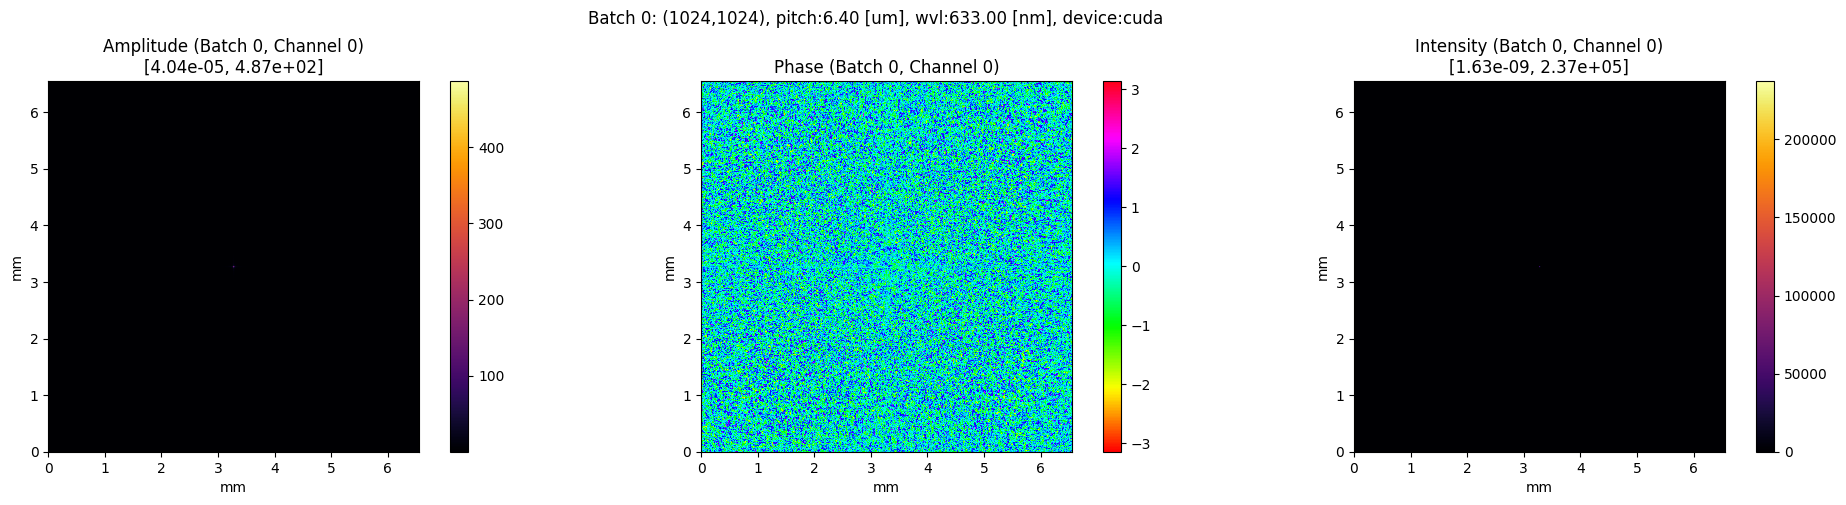

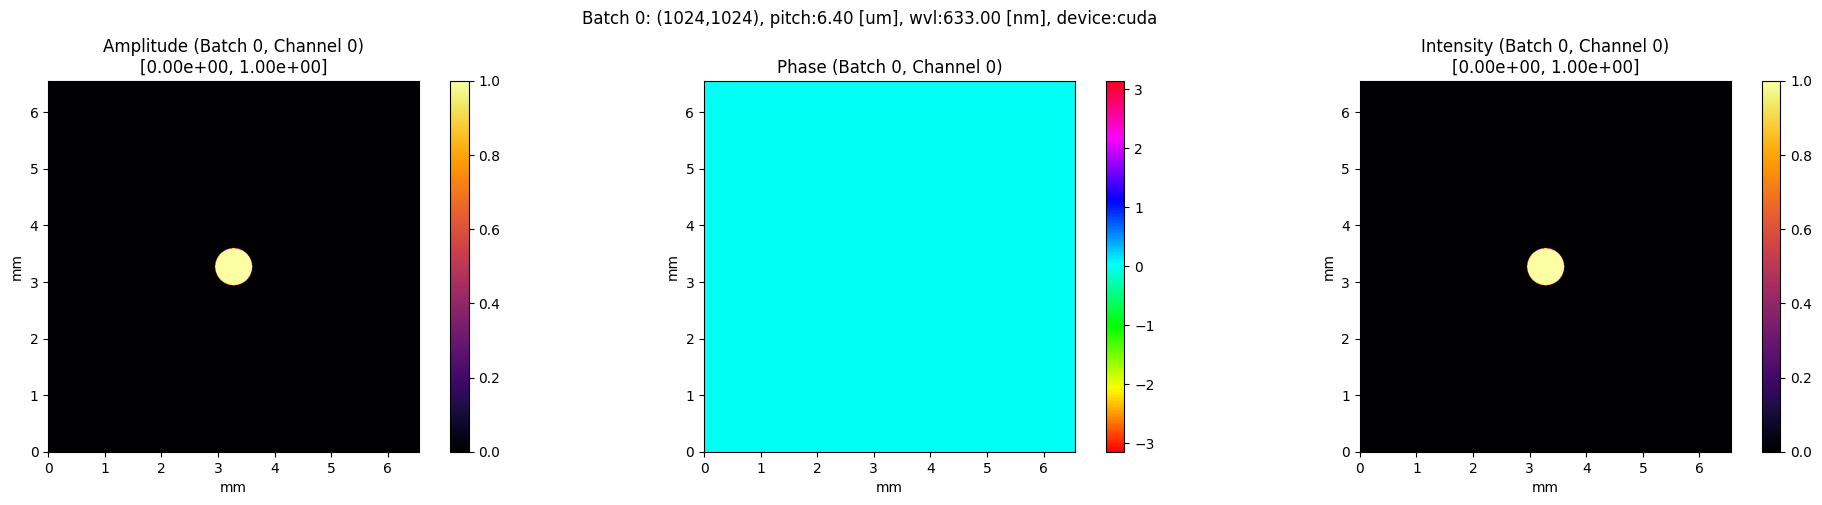

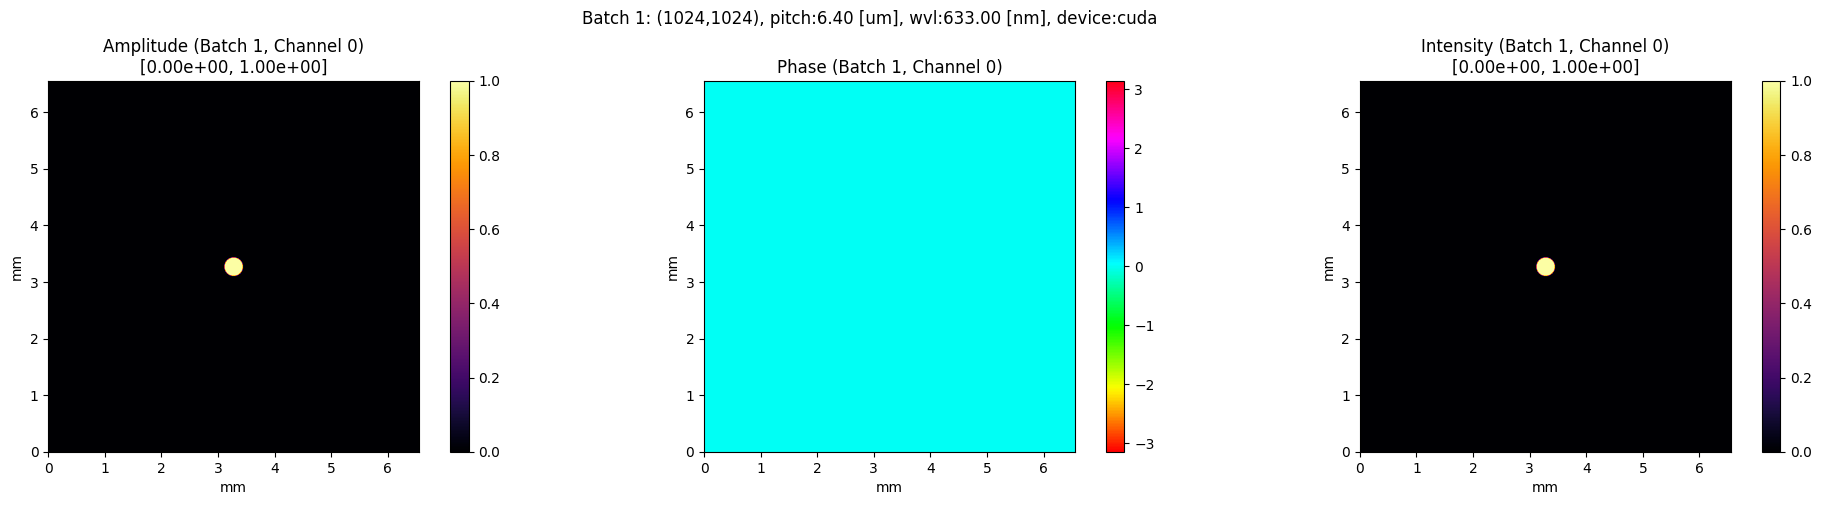

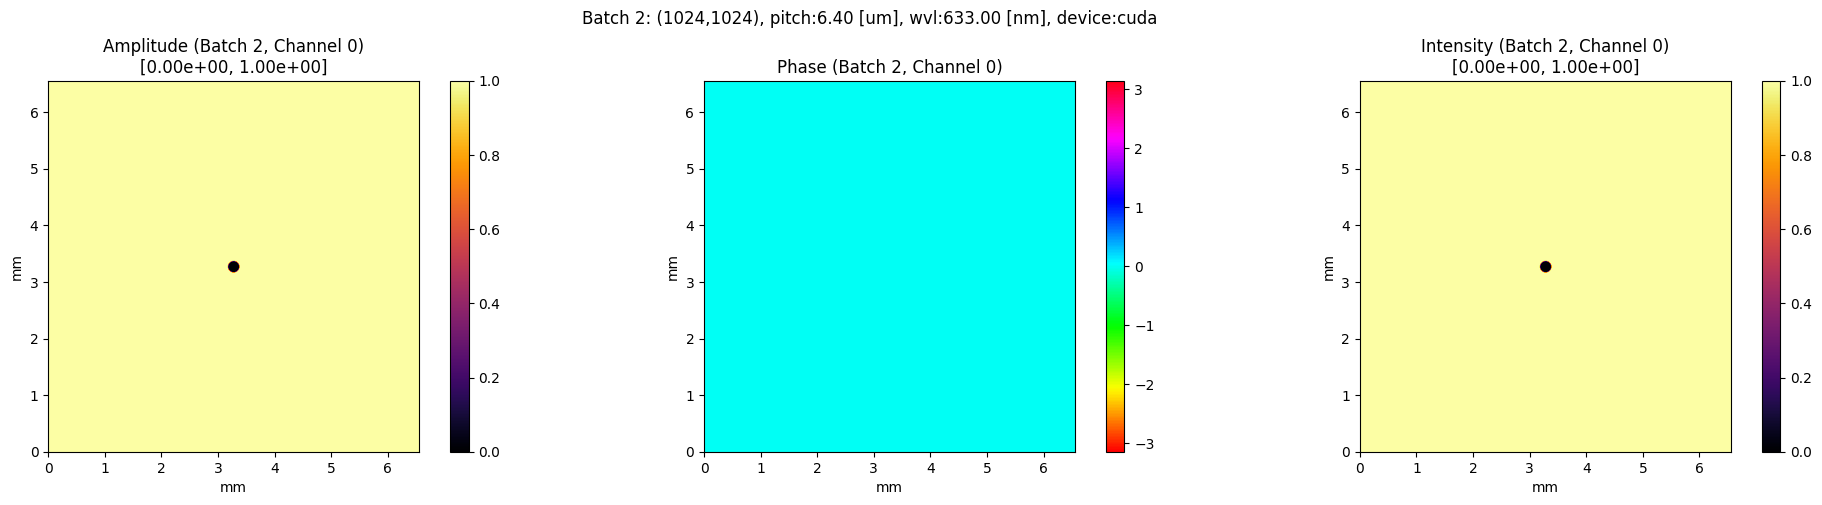

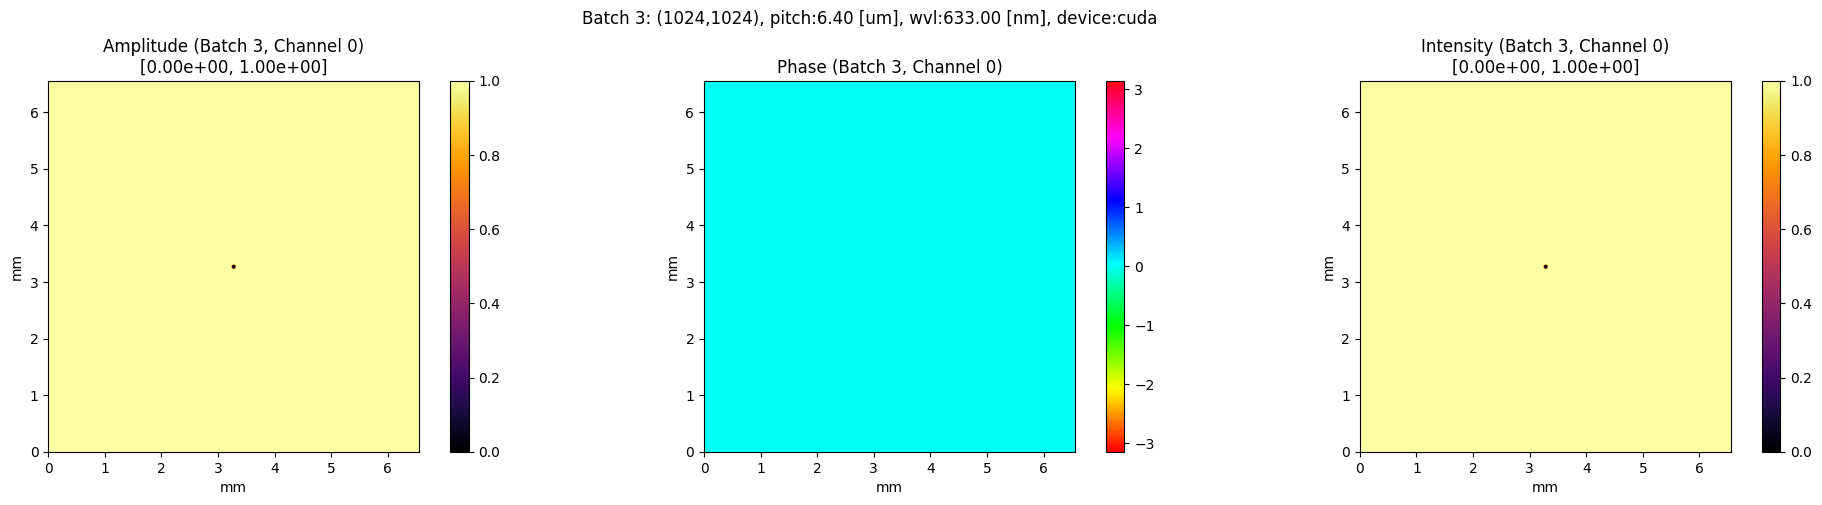

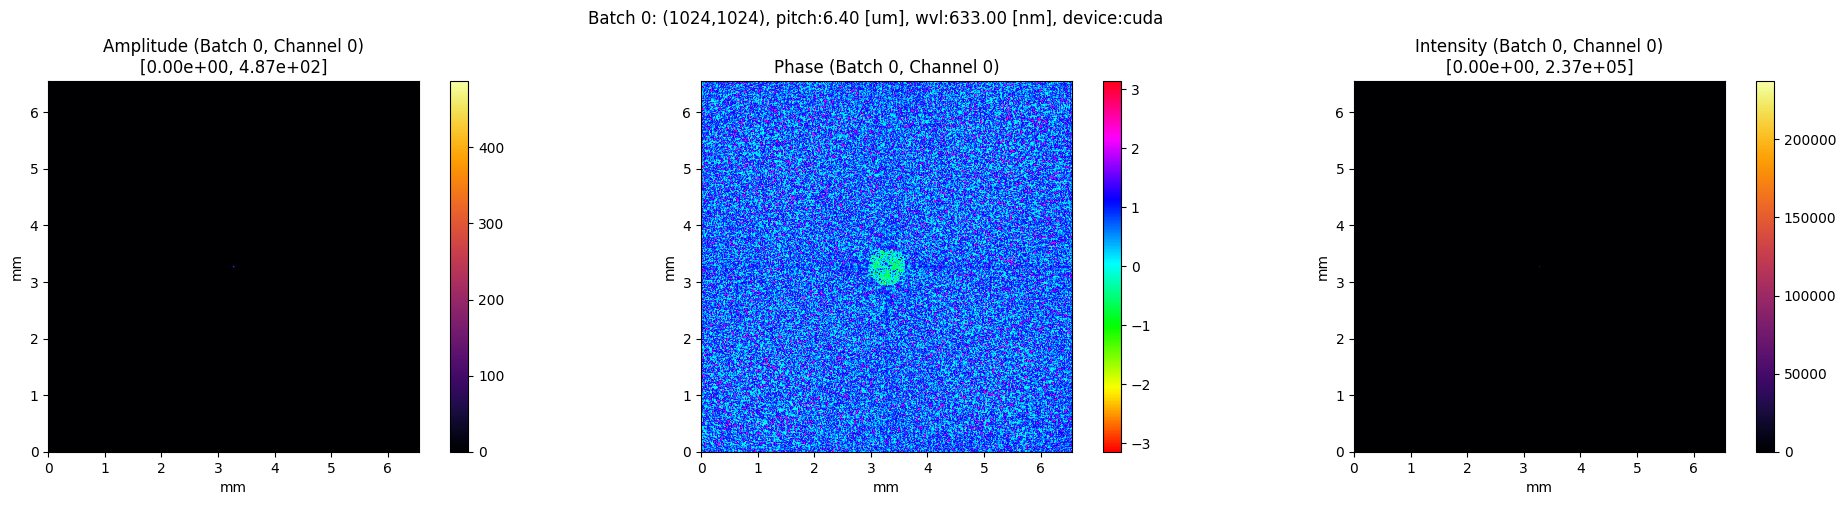

Batch 0: Low-pass filter result


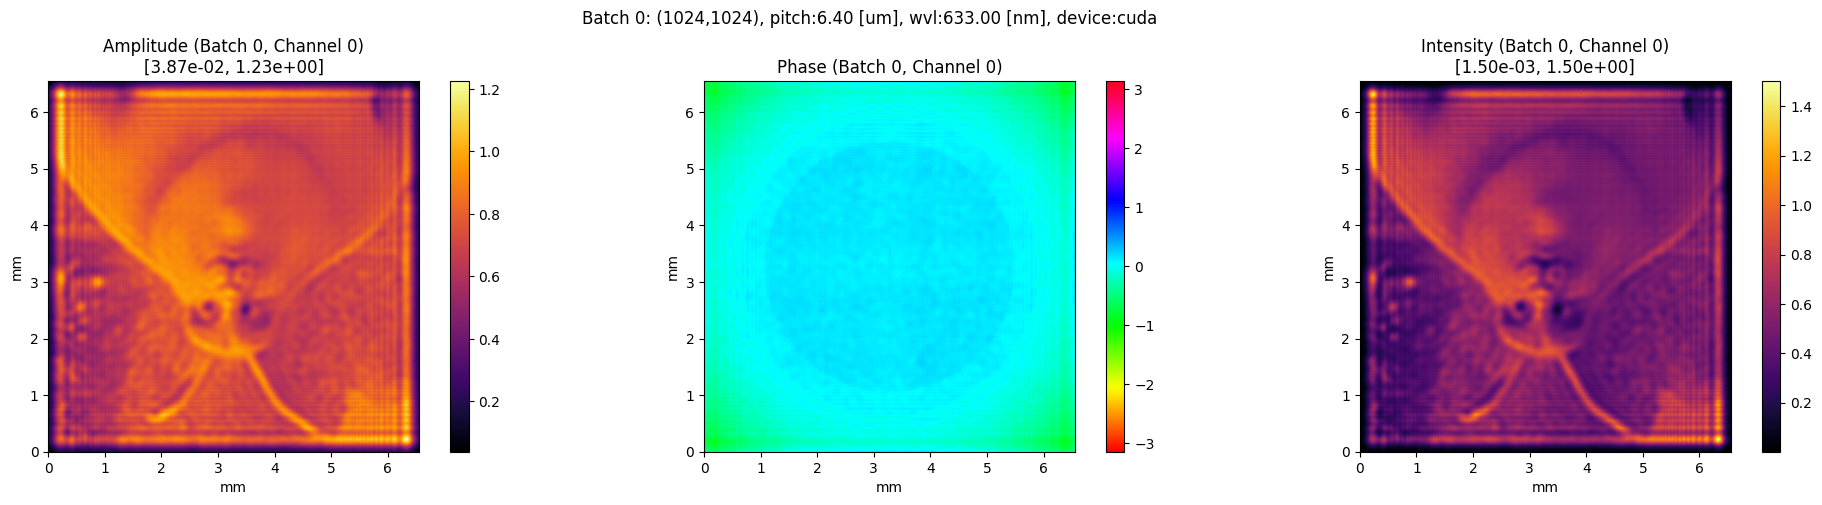

Batch 1: Low-pass filter result


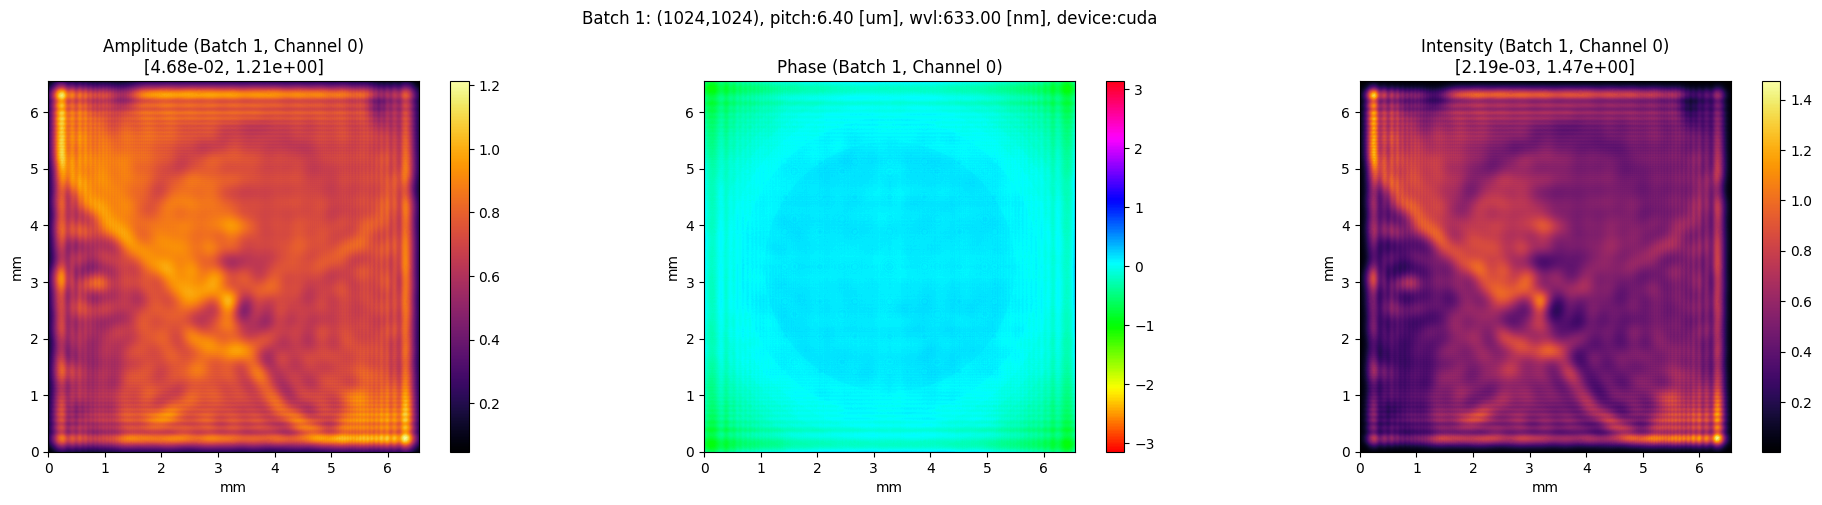

Batch 2: High-pass filter result


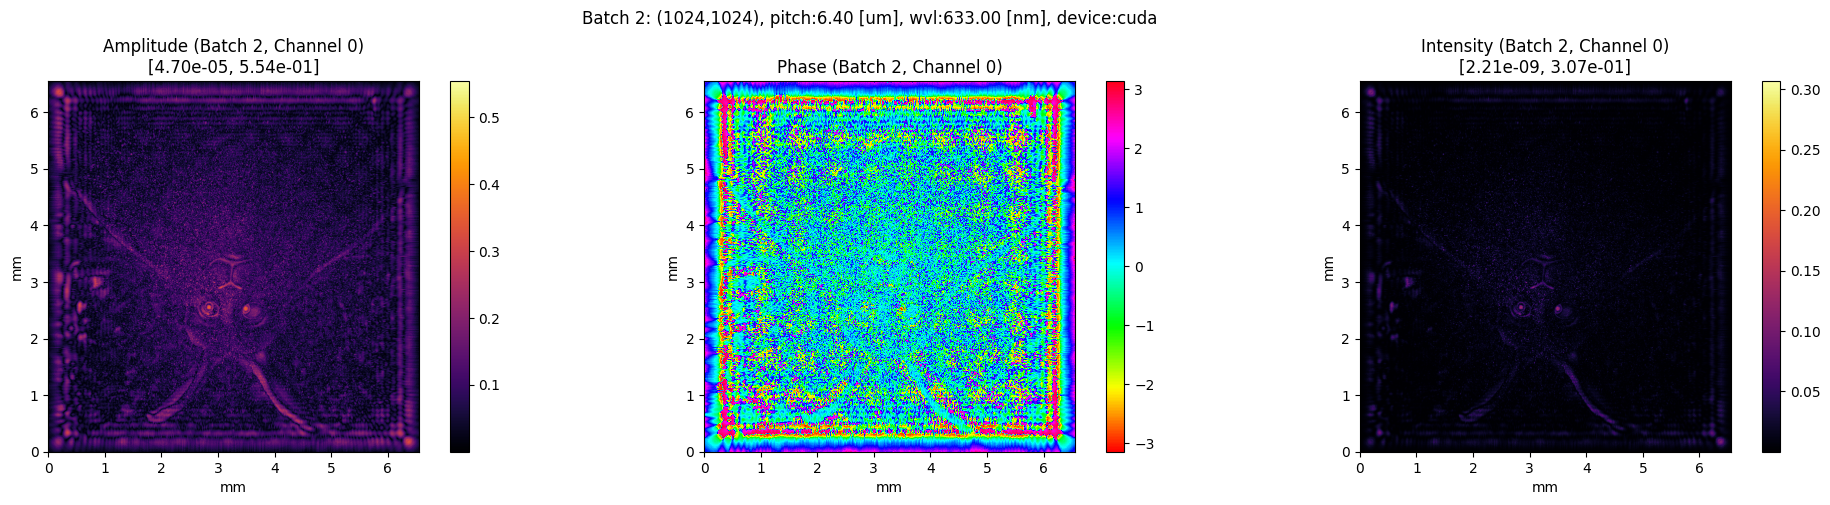

Batch 3: High-pass filter result


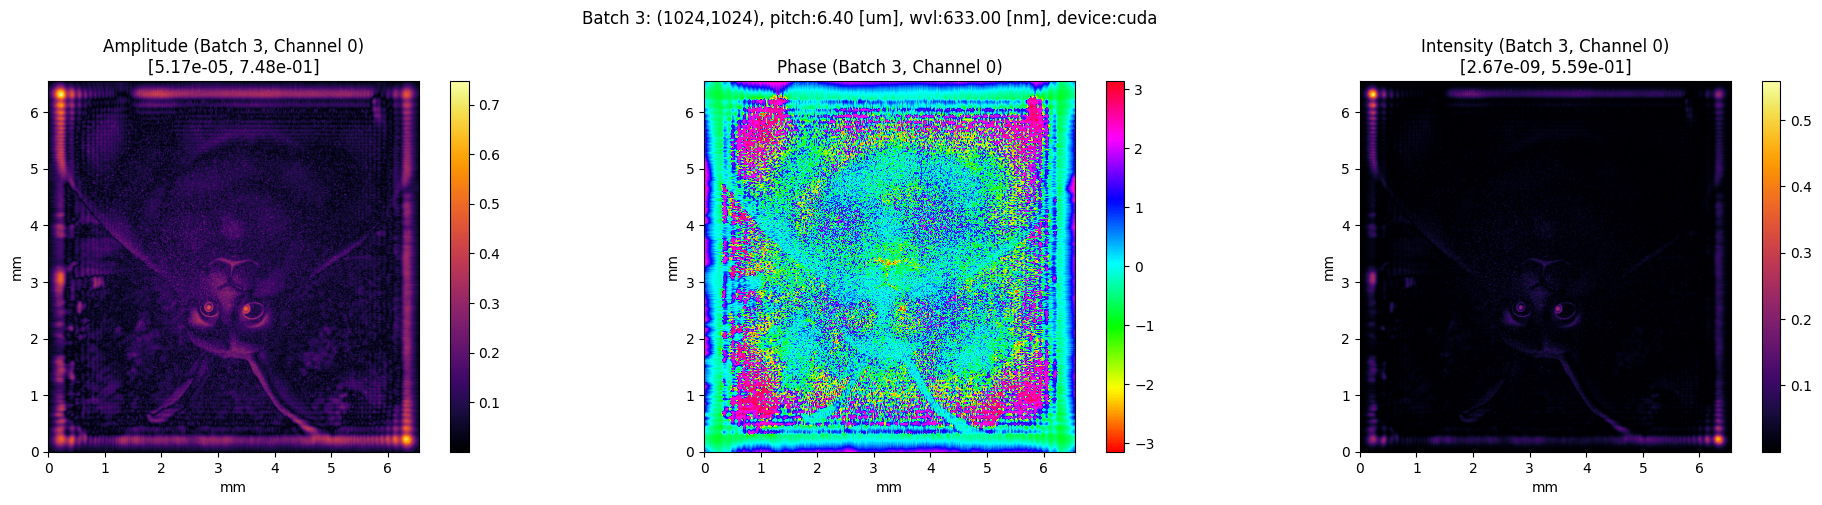

In [5]:
# Create filters for each batch and apply 4F system
filter_light = create_batch_filters(
    dim, 
    pitch, 
    radius_ratios=[0.10, 0.05, 0.03, 0.01],  # Different radius ratios
    filter_types=['low', 'low', 'high', 'high']  # 2 low-pass, 2 high-pass
)

# Apply 4F system to all batches at once
output_light = apply_4F_system(input_light, lens1, lens2, filter_light)

# Visualize results for each batch
for b in range(dim[0]):
    print(f"Batch {b}: {'Low-pass' if b < 2 else 'High-pass'} filter result")
    output_light.visualize(b=b)